# Capstone 2 Pre-processing and Training Data Development

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   **Pre-processing and Training Data Development**
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   Modeling 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
df2.head()

,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Daily
Date,,,,,,,,,,,,,,
2016-01-04,16.39,36.27,78.68,51.44,57.70,148.93,74.55,50.34,56.02,79.35,58.34,31.68,0.00,739.69
2016-01-05,22.45,27.75,7.25,30.64,100.67,149.72,43.14,68.53,93.65,75.90,27.45,31.70,0.00,678.85
2016-01-06,33.59,41.48,111.56,92.00,94.83,94.27,45.26,70.35,57.22,52.53,46.87,49.12,0.00,789.08
2016-01-07,8.40,23.30,54.49,42.28,116.13,101.65,52.04,47.96,128.00,77.01,91.02,75.42,0.00,817.70
2016-01-08,27.25,86.00,48.34,65.21,186.20,158.67,93.76,117.30,143.23,105.70,182.96,89.71,64.12,1368.45


# Rolling Statistics (visual stationary test)

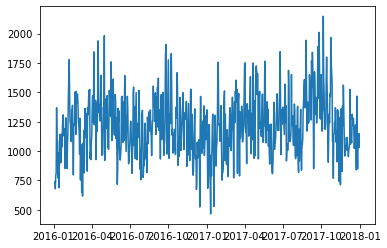

In [7]:
plt.plot(df2.Daily)
plt.show()

In [6]:
# determing rolling statistics, we'll use window = 7 per for weekly rolling
rolmean2 = df2.Daily.rolling(window=7).mean()
rolmean6 = df6.Daily.rolling(window=7).mean()
rolmean7 = df7.Daily.rolling(window=7).mean()

rolstd2 = df2.Daily.rolling(window=7).std()
rolstd6 = df6.Daily.rolling(window=7).std()
rolstd7 = df7.Daily.rolling(window=7).std()

Date
2016-01-04            NaN
2016-01-05            NaN
2016-01-06            NaN
2016-01-07            NaN
2016-01-08            NaN
                 ...     
2017-12-27    1069.353675
2017-12-28    1063.305104
2017-12-29    1036.830818
2017-12-30    1056.997961
2017-12-31    1084.414945
Name: Daily, Length: 728, dtype: float64

# ADCF Test for stationary